In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
from sklearn.model_selection import StratifiedKFold

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
# ------------------ 0. Konfigurasi ------------------
DATA_FILENAME = "breast+cancer+wisconsin+diagnostic\wdbc.data"   # DATASET
FEATURE_NAMES = [
    "radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
    "compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean",
    "radius_se","texture_se","perimeter_se","area_se","smoothness_se",
    "compactness_se","concavity_se","concave_points_se","symmetry_se","fractal_dimension_se",
    "radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst",
    "compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"
]
N_TOTAL_EXPECTED = 569
N_TRAIN_VAL = 455
N_TEST = N_TOTAL_EXPECTED - N_TRAIN_VAL  # 114

In [4]:
# HyperPatameter PSO
SWARM_SIZE = 50
MAX_ITERS = 500          # SWARM_SIZE * MAX_ITERS = total fitness evals (<= max_evals)
MAX_EVALS = 100000
W_INERTIA = 0.72
C1 = 1.4
C2 = 1.4
POS_CLIP = (-20.0, 20.0)  # clamp weight values (optional)
VEL_CLIP = 5.0

# Regularization penalty in fitness (tie-breaker) -> penalize large norms
REG_PENALTY = 1e-4

In [5]:
# ------------------ 1. Load dataset ------------------
if not os.path.exists(DATA_FILENAME):
    raise FileNotFoundError(f"File '{DATA_FILENAME}' not found in current directory. Please download it from UCI and place it here.")

# wdbc.data format: id, diagnosis (M/B), 30 numeric features
df_raw = pd.read_csv(DATA_FILENAME, header=None)
# take first 32 columns (id, diagnosis, 30 features)
if df_raw.shape[1] < 32:
    raise ValueError(f"Unexpected file format: expected at least 32 columns, got {df_raw.shape[1]}")
df = df_raw.iloc[:, :32].copy()
cols = ["id","diagnosis"] + FEATURE_NAMES
df.columns = cols

# drop id
df = df.drop(columns=["id"])
# map diagnosis to numeric labels: B->0, M->1
df['label'] = df['diagnosis'].map({'B':0,'M':1}).astype(int)
df = df.drop(columns=['diagnosis'])

# quick sanity check
if len(df) != N_TOTAL_EXPECTED:
    print(f"Warning: file has {len(df)} rows (expected {N_TOTAL_EXPECTED}) — proceed anyway.")

In [20]:
print(df.head)

<bound method NDFrame.head of      radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     compactness_mean  concavity_

In [6]:
# ------------------ 2. Stratified split train_val (455) / test (114) ------------------
def stratified_split(df, n_first, label_col='label', seed=RANDOM_SEED):
    df_shuf = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    counts = df_shuf[label_col].value_counts().to_dict()
    total = len(df_shuf)
    allocation = {}
    for cls, cnt in counts.items():
        allocation[cls] = int(round(cnt * (n_first / total)))
    # fix rounding
    allocated = sum(allocation.values())
    diff = n_first - allocated
    if diff != 0:
        remainders = {cls: (counts[cls]*(n_first/total) - allocation[cls]) for cls in allocation}
        for cls in sorted(remainders, key=remainders.get, reverse=True)[:abs(diff)]:
            allocation[cls] += 1 if diff>0 else -1
    idx_first = []
    idx_second = []
    for cls, take in allocation.items():
        rows = df_shuf[df_shuf[label_col]==cls]
        idx_first += list(rows.index[:take])
        idx_second += list(rows.index[take:])
    first = df_shuf.loc[idx_first].reset_index(drop=True)
    second = df_shuf.loc[idx_second].reset_index(drop=True)
    return first, second

train_val_df, test_df = stratified_split(df, n_first=N_TRAIN_VAL)
assert len(train_val_df) == N_TRAIN_VAL and len(test_df) == N_TEST, "Stratified sizes mismatch"

print("Label distribution (whole):", df['label'].value_counts().to_dict())
print("Label distribution (train_val):", train_val_df['label'].value_counts().to_dict())
print("Label distribution (test):", test_df['label'].value_counts().to_dict())

# save csvs for submission
Path(".").mkdir(parents=True, exist_ok=True)
train_val_df.to_csv("train_val.data.csv", index=False)
test_df.to_csv("test.data.csv", index=False)
print("Saved train_val.data.csv and test.data.csv")


Label distribution (whole): {0: 357, 1: 212}
Label distribution (train_val): {0: 285, 1: 170}
Label distribution (test): {0: 72, 1: 42}
Saved train_val.data.csv and test.data.csv


In [7]:
# ------------------ 3. Standardize features using train_val stats ------------------
X_train_val = train_val_df[FEATURE_NAMES].values.astype(float)
y_train_val = train_val_df['label'].values.astype(int)
mean_vec = X_train_val.mean(axis=0)
std_vec = X_train_val.std(axis=0, ddof=0)
std_vec[std_vec==0] = 1.0

def standardize(X, mean=mean_vec, std=std_vec):
    return (X - mean) / std

X_train_val_std = standardize(X_train_val)
X_test = test_df[FEATURE_NAMES].values.astype(float)
X_test_std = standardize(X_test)
y_test = test_df['label'].values.astype(int)


In [8]:
# ------------------ 4. Split train_val -> train / val (80/20) stratified ------------------
def stratified_train_val_split(df, val_frac=0.2, label_col='label', seed=RANDOM_SEED):
    df_shuf = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    classes = df_shuf[label_col].unique()
    train_idx = []
    val_idx = []
    for c in classes:
        rows = df_shuf[df_shuf[label_col]==c]
        n_val = int(round(len(rows) * val_frac))
        val_idx += list(rows.index[:n_val])
        train_idx += list(rows.index[n_val:])
    train = df_shuf.loc[train_idx].reset_index(drop=True)
    val = df_shuf.loc[val_idx].reset_index(drop=True)
    return train, val

train_df, val_df = stratified_train_val_split(train_val_df, val_frac=0.2)
X_train = standardize(train_df[FEATURE_NAMES].values.astype(float))
y_train = train_df['label'].values.astype(int)
X_val = standardize(val_df[FEATURE_NAMES].values.astype(float))
y_val = val_df['label'].values.astype(int)

# convert labels for hinge-prediction {+1,-1}
y_train_svm = np.where(y_train==1, 1, -1)
y_val_svm = np.where(y_val==1, 1, -1)
y_test_svm = np.where(y_test==1, 1, -1)
y_train_val_svm = np.where(y_train_val == 1, 1, -1)

In [9]:
# ------------------ 5. Baseline Linear SVM (No PSO) ------------------

def train_linear_svm_scratch(X, y, lr=0.001, C=1.0, n_epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0.0

    for epoch in range(n_epochs):
        for i in range(n_samples):
            condition = y[i] * (np.dot(X[i], w) + b) >= 1
            if condition:
                # only regularization term
                w -= lr * w
            else:
                # hinge loss active
                w -= lr * (w - C * y[i] * X[i])
                b += lr * C * y[i]

    return w, b

def svm_predict(w, b, X):
    scores = np.dot(X, w) + b
    return np.where(scores >= 0, 1, -1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)

    return precision, recall, f1



In [10]:
# train baseline SVM
w_base, b_base = train_linear_svm_scratch(
    X_train_val_std,
    y_train_val_svm,
    lr=0.001,
    C=1.0,
    n_epochs=1000
)

# predict test
baseline_preds = svm_predict(w_base, b_base, X_test_std)
baseline_preds_binary = np.where(baseline_preds == 1, 1, 0)

baseline_acc = accuracy(y_test, baseline_preds_binary)
baseline_prec, baseline_rec, baseline_f1 = precision_recall_f1(
    y_test, baseline_preds_binary
)

print("\n--- Baseline Linear SVM (Scratch) ---")
print(f"Accuracy : {baseline_acc:.4f}")
print(f"Precision: {baseline_prec:.4f}")
print(f"Recall   : {baseline_rec:.4f}")
print(f"F1-score : {baseline_f1:.4f}")



--- Baseline Linear SVM (Scratch) ---
Accuracy : 0.9386
Precision: 1.0000
Recall   : 0.8333
F1-score : 0.9091


In [11]:
# ------------------ 6. Linear SVM from parameter vector ------------------
def svm_scores_from_params(param_vec, X):
    w = param_vec[:-1]
    b = param_vec[-1]
    return np.dot(X, w) + b

def svm_predict_from_params(param_vec, X):
    scores = svm_scores_from_params(param_vec, X)
    return np.where(scores >= 0, 1, -1)


In [12]:
# ------------------ 7. Fitness Function (5-Fold CV Accuracy) ------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def fitness(param_vec):
    accs = []
    for tr_idx, val_idx in skf.split(X_train_val_std, y_train_val_svm):
        preds = svm_predict_from_params(param_vec, X_train_val_std[val_idx])
        acc = np.mean(preds == y_train_val_svm[val_idx])
        accs.append(acc)

    mean_acc = np.mean(accs)
    reg = REG_PENALTY * np.linalg.norm(param_vec[:-1])
    return mean_acc - reg


In [13]:
# ------------------ 8. Continuous PSO ------------------
class ContinuousPSO:
    def __init__(self, n_dim, fitness_func, swarm_size, max_iters,
                 w, c1, c2, vel_clip, pos_clip, max_evals, seed):
        self.n_dim = n_dim
        self.fitness_func = fitness_func
        self.swarm_size = swarm_size
        self.max_iters = max_iters
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.vel_clip = vel_clip
        self.pos_clip = pos_clip
        self.max_evals = max_evals

        np.random.seed(seed)
        self.pos = np.random.normal(0, 0.5, (swarm_size, n_dim))
        self.vel = np.random.normal(0, 0.1, (swarm_size, n_dim))

        self.pbest_pos = self.pos.copy()
        self.pbest_fit = np.full(swarm_size, -np.inf)

        self.gbest_pos = None
        self.gbest_fit = -np.inf
        self.eval_count = 0
        self.history = []

    def run(self):
        for it in range(1, self.max_iters + 1):

            evals_before = self.eval_count

            for i in range(self.swarm_size):
                if self.eval_count >= self.max_evals:
                    break

                fit = self.fitness_func(self.pos[i])
                self.eval_count += 1

                if fit > self.pbest_fit[i]:
                    self.pbest_fit[i] = fit
                    self.pbest_pos[i] = self.pos[i].copy()

                if fit > self.gbest_fit:
                    self.gbest_fit = fit
                    self.gbest_pos = self.pos[i].copy()

            for i in range(self.swarm_size):
                r1, r2 = np.random.rand(self.n_dim), np.random.rand(self.n_dim)
                self.vel[i] = (
                    self.w * self.vel[i]
                    + self.c1 * r1 * (self.pbest_pos[i] - self.pos[i])
                    + self.c2 * r2 * (self.gbest_pos - self.pos[i])
                )

                if self.vel_clip:
                    self.vel[i] = np.clip(self.vel[i], -self.vel_clip, self.vel_clip)

                self.pos[i] += self.vel[i]

                if self.pos_clip:
                    self.pos[i] = np.clip(self.pos[i], *self.pos_clip)


            self.history.append(
                (it, self.gbest_fit, self.eval_count)
            )

            print(
                f"Iter {it:03d} | "
                f"Best fitness: {self.gbest_fit:.4f} | "
                f"Total evals: {self.eval_count:6d}"
            )

            if self.eval_count >= self.max_evals:
                print("⚠ Max evaluations reached. Stopping PSO.")
                break

        return self.gbest_pos, self.gbest_fit, self.history



In [14]:
# ------------------ 9. Run PSO ------------------
n_dim = X_train_val_std.shape[1] + 1

pso = ContinuousPSO(
    n_dim=n_dim,
    fitness_func=fitness,
    swarm_size=SWARM_SIZE,
    max_iters=MAX_ITERS,
    w=W_INERTIA,
    c1=C1,
    c2=C2,
    vel_clip=VEL_CLIP,
    pos_clip=POS_CLIP,
    max_evals=MAX_EVALS,
    seed=RANDOM_SEED
)

best_vec, best_fit, history = pso.run()


Iter 001 | Best fitness: 0.8942 | Total evals:     50
Iter 002 | Best fitness: 0.9206 | Total evals:    100
Iter 003 | Best fitness: 0.9446 | Total evals:    150
Iter 004 | Best fitness: 0.9512 | Total evals:    200
Iter 005 | Best fitness: 0.9576 | Total evals:    250
Iter 006 | Best fitness: 0.9576 | Total evals:    300
Iter 007 | Best fitness: 0.9576 | Total evals:    350
Iter 008 | Best fitness: 0.9598 | Total evals:    400
Iter 009 | Best fitness: 0.9687 | Total evals:    450
Iter 010 | Best fitness: 0.9708 | Total evals:    500
Iter 011 | Best fitness: 0.9709 | Total evals:    550
Iter 012 | Best fitness: 0.9730 | Total evals:    600
Iter 013 | Best fitness: 0.9752 | Total evals:    650
Iter 014 | Best fitness: 0.9752 | Total evals:    700
Iter 015 | Best fitness: 0.9796 | Total evals:    750
Iter 016 | Best fitness: 0.9796 | Total evals:    800
Iter 017 | Best fitness: 0.9817 | Total evals:    850
Iter 018 | Best fitness: 0.9817 | Total evals:    900
Iter 019 | Best fitness: 0.9

In [15]:
# ------------------ 10. PSO-SVM Test Evaluation ------------------
test_preds_svm = svm_predict_from_params(best_vec, X_test_std)
test_preds_binary = np.where(test_preds_svm == 1, 1, 0)

test_acc = accuracy(y_test, test_preds_binary)
prec, rec, f1 = precision_recall_f1(y_test, test_preds_binary)

print("\n--- PSO-Optimized Linear SVM ---")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")




--- PSO-Optimized Linear SVM ---
Accuracy : 0.9649
Precision: 1.0000
Recall   : 0.9048
F1-score : 0.9500


In [16]:
comparison = pd.DataFrame({
    "Model": ["Baseline Linear SVM", "PSO-Optimized Linear SVM"],
    "Accuracy": [baseline_acc, test_acc],
    "Precision": [baseline_prec, prec],
    "Recall": [baseline_rec, rec],
    "F1-score": [baseline_f1, f1]
})

print("\n=== FINAL COMPARISON ===")
print(comparison.to_string(index=False))

print("\n=== PERFORMANCE IMPROVEMENT ===")
print(f"Accuracy Improvement : {test_acc - baseline_acc:+.4f}")
print(f"F1-score Improvement : {f1 - baseline_f1:+.4f}")



=== FINAL COMPARISON ===
                   Model  Accuracy  Precision   Recall  F1-score
     Baseline Linear SVM  0.938596        1.0 0.833333  0.909091
PSO-Optimized Linear SVM  0.964912        1.0 0.904762  0.950000

=== PERFORMANCE IMPROVEMENT ===
Accuracy Improvement : +0.0263
F1-score Improvement : +0.0409


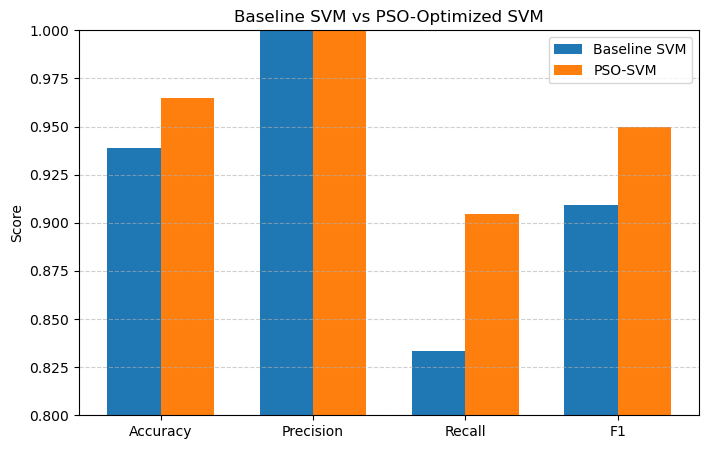

In [17]:
# Chart perbandingan Performance
plt.figure(figsize=(8,5))
x = np.arange(4)
width = 0.35

plt.bar(x - width/2,
        [baseline_acc, baseline_prec, baseline_rec, baseline_f1],
        width, label="Baseline SVM")

plt.bar(x + width/2,
        [test_acc, prec, rec, f1],
        width, label="PSO-SVM")

plt.xticks(x, ["Accuracy", "Precision", "Recall", "F1"])
plt.ylim(0.8, 1.0)
plt.ylabel("Score")
plt.title("Baseline SVM vs PSO-Optimized SVM")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


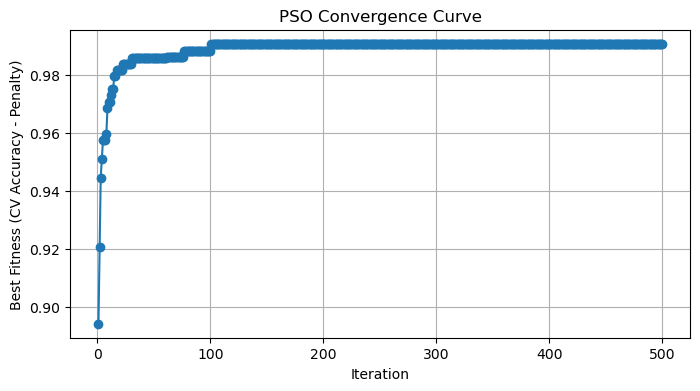

In [18]:
# PSO Convergence Curve
hist_df = pd.DataFrame(history, columns=["Iteration", "BestFitness", "TotalEvals"])

plt.figure(figsize=(8,4))
plt.plot(hist_df["Iteration"], hist_df["BestFitness"], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best Fitness (CV Accuracy - Penalty)")
plt.title("PSO Convergence Curve")
plt.grid(True)
plt.show()
